In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [5]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [6]:
mu_nback = torch.mean(nback_p_t, dim=0, keepdim=True)
mu_emoid = torch.mean(emoid_p_t, dim=0, keepdim=True)
std_nback = torch.std(nback_p_t, dim=0, keepdim=True)
std_emoid = torch.std(emoid_p_t, dim=0, keepdim=True)

nback_p_t = (nback_p_t - mu_nback)/std_nback
emoid_p_t = (emoid_p_t - mu_emoid)/std_emoid

print(torch.min(nback_p_t[:,420:422],dim=0))
print(torch.min(emoid_p_t[:,420:422],dim=0))

torch.return_types.min(
values=tensor([-2.2998, -3.0133], device='cuda:0'),
indices=tensor([603, 350], device='cuda:0'))
torch.return_types.min(
values=tensor([-2.7284, -3.0616], device='cuda:0'),
indices=tensor([351,  33], device='cuda:0'))


In [7]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

(620,)
(620, 2)
(620,)
Complete


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import time

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()

rmse = []
Ass = []
features = []

def allBelowThresh(losses, thresh):
    for loss,thr in zip(losses, thresh):
        if loss > thr:
            return False
    return True

def flatten(res):
    flat = [r for re in res for r in re]
    return flat

def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

def arith(n):
    return int(n*(n+1)/2)

def getAvg(res):
    nPara = len(res)
    nTasks = len(res[0])
    avg = []
    for task in range(nTasks):
        avg.append(0)
        for para in range(nPara):
            avg[-1] += res[para][task]/nPara
    return avg

class LatSim(nn.Module):
    def __init__(self, nTasks, inp, dp=0.5, edp=0.1, adp=0.1, wInit=1e-4, dimA=2, dimB=2, temp=1):
        super(LatSim, self).__init__()
        self.nTasks = nTasks
        self.A = nn.Parameter(wInit*torch.randn(2,inp.shape[-1],dimA).float().cuda())
        self.B = nn.Parameter(wInit*torch.randn(2,nTasks,dimA,dimB).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
        self.adp = nn.Dropout(p=adp)
        self.t = temp if isinstance(temp, list) else nTasks*[temp]
    
    def getLatent(self, x, para):
        return x[:,para]@self.A[para]
    
    def getEdges(self, A, para, task):
        e = 1e-10
        z = A@self.B[para, task]
        e = e+z@z.T
        return e
        
    def forward(self, x, ys, testIdcs=None):
        assert self.B.shape[1] == len(ys), "business end targets dim not same as passed"
        x = self.dp(x)
        res = []
        As = []
        es = []
        for para in range(2):
            A = self.getLatent(x, para)
            As.append(self.adp(F.relu(A)))
        for para,A in enumerate(As):
            res.append([])
            for task,y in enumerate(ys):
                e = self.getEdges(A, para, task)
                if testIdcs is not None:
                    e[:,testIdcs] = 0
                e = mask(e)
                e = self.edp(e)
                e[e == 0] = float('-inf')
                e = F.softmax(e/self.t[task], dim=1)
                res[-1].append(e@y)
        return res, As, es

def validate(model, X, ys, testIdcs):
    model.eval()
    losses = []
    with torch.no_grad():
        res, _, _ = model(X, ys, testIdcs)
        # for r,y in zip(res, ys):
        for r,y in zip(getAvg(res), ys):
            if y.dim() == 1:
                loss = mseLoss(r[testIdcs], y[testIdcs]).cpu().numpy()**0.5
                losses.append(loss)
            else:
                corr = (torch.argmax(r, dim=1) == torch.argmax(y, dim=1))[testIdcs]
                loss = torch.sum(corr)/len(testIdcs)
                losses.append(loss)
    model.train()
    return losses

def getAs(model, X, ys):
    model.eval()
    As = None
    with torch.no_grad():
        _, As, _ = model(X, ys)
    model.train()
    return As

def binLoss(w):
    mag = torch.abs(w)
    maxMag = torch.max(mag, keepdim=True, dim=1).values
    p = mag/maxMag
    return -torch.sum(p*torch.log(p+1e-10))

def getFeatures(sim, X, yy, task=0, para=0, testIdcs=None):
    #sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))
    sim.eval()
    allDims = []
    with torch.no_grad():
        y = yy[task][testIdcs]
        if y.dim() == 1:
            y = y.unsqueeze(1)
        for dim in range(sim.A.shape[2]):
            mult = torch.sum((sim.B[para,task,dim,:].detach())**2)/2
            d = torch.cdist(y, y)
            d = d - torch.mean(d)
            m = torch.einsum('ad,d->ad', X[testIdcs,para,:], sim.A[para,:,dim].detach())
            sm = F.relu(torch.sum(m, dim=1))
            smi = sm > 0
            whole = []
            for i0 in range(0,34700,1000):
                i1 = i0+1000
                mm = torch.einsum('ad,a,b->abd', m[:,i0:i1], smi, sm)
                part = torch.einsum('ab,abd->d', d, mm)
                whole.append(part)
            whole = torch.cat(whole)
        allDims.append(mult*whole)
    sim.train()
    return torch.mean(torch.stack(allDims), axis=0)

nEpochs = 1000
pPeriod = 50
thresh = [20,0.3,10]
regParam = [1,1e3,20]
binParam = 1e-1

for rep in range(1):
    for grp in range(10):
        trainIdcs = groups[grp][0][0:496]
        trainValidIdcs = groups[grp][0]
        validIdcs = np.arange(496,len(trainValidIdcs))
        testIdcs = groups[grp][1]

        X0 = nback_p_t
        X1 = emoid_p_t

        X = torch.stack([X0, X1], dim=1)
        Xt = X[trainIdcs]
        Xtv = X[trainValidIdcs]

        yy = [age_t, gen_t, wrt_t]
        yt = [age_t[trainIdcs], gen_t[trainIdcs], wrt_t[trainIdcs]]
        ytv = [age_t[trainValidIdcs], gen_t[trainValidIdcs], wrt_t[trainValidIdcs]]

    #     yy = yy[2:]
    #     yt = yt[2:]
    #     ytv = ytv[2:]

        nTasks = len(yy)

        sim = LatSim(nTasks, X, dp=0.5, edp=0.1, adp=0.3, wInit=1e-4, dimA=20, dimB=2, temp=[1,1,1])
        optim = torch.optim.Adam(sim.parameters(), lr=5e-4, weight_decay=5e-4)

        validLoss = [[] for _ in range(nTasks)]

        for epoch in range(nEpochs):
            optim.zero_grad()
            res, As, _ = sim(Xt, yt)
            loss = []
            for i,(r,y) in enumerate(zip(flatten(res)+getAvg(res), (X.shape[1]+1)*yt)):
                if y.dim() > 1:
                    loss.append(regParam[i%nTasks]*ceLoss(r, y))
                else:
                    loss.append(regParam[i%nTasks]*mseLoss(r, y))
            bloss = [binParam*binLoss(sim.A)]
            loss += bloss
            sum(loss).backward()
            optim.step()
            if epoch % pPeriod == 0 or epoch == nEpochs-1 or allBelowThresh(loss[0:nTasks], thresh):
                print(f'epoch {epoch} loss={bloss}')
                losses = validate(sim, Xtv, ytv, validIdcs)
                for i,lss in enumerate(losses):
                    if (len(validLoss[i]) == 0 or 
                            (yy[i].dim() == 1 and lss < min(validLoss[i])) or 
                            (yy[i].dim() > 1 and lss > max(validLoss[i]))):
                        print(f'New best validation epoch {epoch} {i} loss={lss}')
                        torch.save(sim.state_dict(), f'../../Work/LatentSim/sim{i}.pyt')
                        validLoss[i].append(float(lss))
                if allBelowThresh(loss[0:nTasks], thresh):
                    print('Early stopping')
                    break

        finalLoss = []
        featPart = np.zeros((2,nTasks,34716))

        for task in range(nTasks):
            sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))
            loss = validate(sim, X, yy, testIdcs)
            finalLoss.append(float(loss[task]))

            for para in range(2):
                feat = getFeatures(sim, X, yy, task, para, testIdcs)
                featPart[para,task] = feat.detach().cpu().numpy()

        rmse.append(finalLoss)
        features.append(np.stack(featPart))

        print(f'FINISHED {rmse}')

epoch 0 loss=0
New best validation epoch 0 0 loss=44.58405303955078
New best validation epoch 0 1 loss=0.5
New best validation epoch 0 2 loss=12.045499801635742
epoch 50 loss=0
New best validation epoch 50 0 loss=24.813114166259766
New best validation epoch 50 1 loss=0.6290322542190552
New best validation epoch 50 2 loss=11.19775390625
epoch 100 loss=0
New best validation epoch 100 0 loss=22.420574188232422
epoch 150 loss=0
New best validation epoch 150 1 loss=0.7096773982048035
epoch 200 loss=0
New best validation epoch 200 1 loss=0.7580645084381104
epoch 250 loss=0
New best validation epoch 250 1 loss=0.774193525314331
epoch 300 loss=0
New best validation epoch 300 1 loss=0.8064515590667725
New best validation epoch 300 2 loss=11.11483383178711
epoch 350 loss=0
New best validation epoch 350 2 loss=11.05569839477539
epoch 400 loss=0
epoch 450 loss=0
epoch 500 loss=0
New best validation epoch 500 0 loss=22.414989471435547
epoch 550 loss=0
epoch 600 loss=0
New best validation epoch 600 

epoch 150 loss=0
New best validation epoch 150 1 loss=0.7096773982048035
epoch 200 loss=0
New best validation epoch 200 1 loss=0.8064515590667725
epoch 250 loss=0
New best validation epoch 250 1 loss=0.8548386693000793
epoch 300 loss=0
epoch 350 loss=0
epoch 400 loss=0
epoch 450 loss=0
epoch 500 loss=0
epoch 550 loss=0
epoch 600 loss=0
epoch 650 loss=0
New best validation epoch 650 2 loss=11.24499797821045
epoch 700 loss=0
epoch 750 loss=0
epoch 800 loss=0
epoch 850 loss=0
epoch 900 loss=0
epoch 950 loss=0
epoch 999 loss=0
FINISHED [[25.10388946533203, 0.8225806355476379, 12.127655982971191], [29.145456314086914, 0.7903225421905518, 13.196396827697754], [23.11331558227539, 0.7903225421905518, 11.889805793762207], [23.47641944885254, 0.774193525314331, 15.359285354614258], [23.959522247314453, 0.7903225421905518, 13.21479320526123], [22.96586799621582, 0.7580645084381104, 13.832303047180176]]
epoch 0 loss=0
New best validation epoch 0 0 loss=42.94873809814453
New best validation epoch 0

epoch 999 loss=0
FINISHED [[25.10388946533203, 0.8225806355476379, 12.127655982971191], [29.145456314086914, 0.7903225421905518, 13.196396827697754], [23.11331558227539, 0.7903225421905518, 11.889805793762207], [23.47641944885254, 0.774193525314331, 15.359285354614258], [23.959522247314453, 0.7903225421905518, 13.21479320526123], [22.96586799621582, 0.7580645084381104, 13.832303047180176], [24.20670509338379, 0.8064515590667725, 15.904603958129883], [25.91018295288086, 0.6774193048477173, 15.147693634033203], [23.795108795166016, 0.7419354915618896, 14.89535140991211], [26.60727882385254, 0.7096773982048035, 15.484285354614258]]


In [10]:
print(sum([f[0] for f in rmse])/len(rmse)/12)
print(sum([f[1] for f in rmse])/len(rmse))
print(sum([f[2] for f in rmse])/len(rmse))

2.10797422170639
0.7707257801294327
14.210716857910157


-100.49152973104798
92 94 -0.22216882302517335
92 95 -0.17581603694352707
129 231 -0.17366218148229348
38 137 -0.17051435081478417
99 260 -0.1602448537161763
42 43 -0.15970965581587393
33 38 -0.14772947044949092
225 231 -0.14206870415594908
120 236 -0.13987410679466902
217 219 -0.1392676653159451


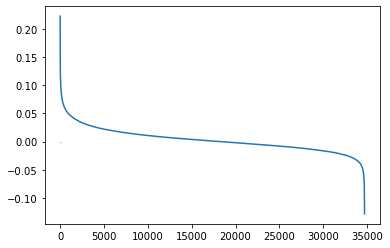

In [20]:
import matplotlib.pyplot as plt

to = 100

ww = np.mean(np.stack(features), axis=0)[0,0,:]
idcs = np.argsort(ww)
a, b = np.triu_indices(264, 1)

print(np.sum(ww))
for i in idcs[0:10]:
    print(a[i],b[i],ww[i])

plt.plot(-ww[idcs])
plt.plot([0,to],[0,0],color='black',linestyle='-.',linewidth=0.5)
plt.show()


In [21]:
wroi = np.zeros(264)

for i in range(264):
    wroi[i] = np.sum(ww[i == a[idcs]])
    
print(np.argsort(wroi))

[  3  14  42  30   9  23  65  12 122  22  45   2 110   4  53  26  40  99
  21  18  44  79  60 112 124  61  88  19  66  34  92  73   7  63  13 113
  69  75 137 155  70  51 117  72  89  43  54  17  74  16 107 191  94 170
 111  35 120  20  62  48 128  33  52 100 146  90 166 140  41  98 175 147
  67  15  50  84  25 104  80  68  97 153 119 171  55 116 108  59 179  24
  86  77   0  36 160 174  95 183   8 125  29 133   6 180 148 130 162  85
 173  46 202 207  27 109  81  28  76   5 152  37 102   1  10 225 193 114
 172 150 190 227 188 214  11  31 176 149 103 213  93 206  91 185 134 101
 168  57  49  58  39  83 164  56 131 157 115 195 126 143 186 169 200 135
 132 159 138 184 178  32 226 121  47  38 215 151 219 250 235 139 198 118
 196 142 158 145 156 247 208 237 204  78 136 167 201 127 189 249 161 223
  64 210 248 234 141 205 154 231 218 216 211 240 203 123 252 253 106 239
 245 224 243  96  71 220 257 254 212 222 163 255 261 263 230 258  87 187
 262 251 259 228 229 144 236 182 217 260 256 232 24

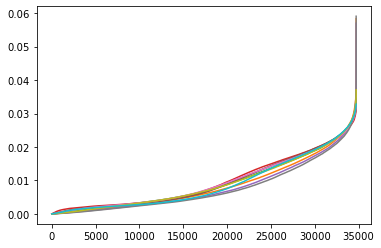

In [43]:
import matplotlib.pyplot as plt

w = sim.A[1].detach().cpu().numpy()

for dim in range(w.shape[1]):
    plt.plot(np.sort(np.abs(w[:,dim])))
plt.show()

In [97]:
import numpy as np

roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap1 = np.zeros(264,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []
roiCounts = np.zeros(14)

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiCounts[area-1] += 1
        roiNames[area] = name
        revMap1[r2-1] = r1-1
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])

last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

def rearrange(p,idcs):
    return p[:,idcs][idcs]

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


In [238]:
a,b = np.triu_indices(264, 1)

wsel = torch.sum(F.relu(torch.einsum('ab,b->ab', emoid_p_t, sim.A[1,:,9])), axis=0).detach().cpu().numpy()
# wsel = np.einsum('ab,b->b', emoid_p_t.detach().cpu().numpy(), w[:,14])
idcs = np.argsort(-np.abs(wsel))[0:1000]

print((a[idcs[0]],b[idcs[0]]))
print(idcs[0:5])

img = np.zeros((264,264))
img[a[idcs],b[idcs]] = wsel[idcs]
img += img.T

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(img)
ax[1].plot(wsel[idcs[0:1000]])
plt.show()

IndexError: index 9 is out of bounds for dimension 2 with size 9

In [200]:
sim.B[1,1,:,:]

tensor([[ 0.0688,  0.0740],
        [ 0.0642,  0.0673],
        [ 0.1473,  0.1502],
        [-0.3110, -0.3093],
        [ 0.1257,  0.1305],
        [ 0.2262,  0.2274],
        [-0.2347, -0.2300],
        [-0.0962, -0.0908],
        [-0.0097, -0.0078],
        [ 0.0402,  0.0424]], device='cuda:0', grad_fn=<SliceBackward0>)

In [182]:
para = 1
task = 0
dim = 19

tasks = [age_t.unsqueeze(1), gen_t, wrt_t.unsqueeze(1)]

sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))

# d = 1/(torch.cdist(tasks[task], tasks[task])+1)
d = torch.cdist(tasks[task], tasks[task])
d = d - torch.mean(d)
m = F.relu(torch.einsum('ad,d->ad', X[:,para,:], sim.A[para,:,dim]))
whole = []
for i0 in range(0,34700,1000):
    i1 = i0+1000
    mm = torch.einsum('ad,bd->abd', m[:,i0:i1], m[:,i0:i1])
    part = torch.einsum('ab,abd->d', d, mm)
    whole.append(part)
    if i0%10000 == 0:
        print(i0)

whole = torch.cat(whole)
idcs = torch.argsort(whole)
print(a[idcs[0]], b[idcs[0]])
print(idcs[0:50])
whole[idcs[0:50]]

0
10000
20000
30000
3 4
tensor([  786,  7210, 10017, 11873, 14449, 16815, 14472,  3898, 27596, 16848,
        15851, 28358,  6846, 21591, 21519, 16854, 22048, 34480, 24407, 20698,
        11447, 11030, 26710,  7107, 18220,   133,  9530, 15391,  7920, 16907,
        10043, 25849,  7337, 30916, 15544, 16138, 27942, 24391,  1545, 24087,
         7319,  9622, 29434, 31237,  2061, 30592, 21187, 16809, 24427, 12607],
       device='cuda:0')


tensor([-3625.0200, -1221.1321,  -849.2945,  -804.7903,  -787.3834,  -766.0433,
         -685.7000,  -639.3873,  -600.9178,  -593.9639,  -529.9984,  -501.9200,
         -485.5863,  -479.1000,  -465.7836,  -394.0397,  -382.0023,  -377.4489,
         -352.2688,  -325.1320,  -319.1778,  -318.6790,  -313.1548,  -310.0072,
         -308.9245,  -307.2779,  -307.2657,  -304.0557,  -303.8903,  -295.3653,
         -290.9072,  -290.1482,  -286.8635,  -284.8821,  -278.4120,  -277.2310,
         -274.5107,  -266.8559,  -261.4293,  -260.5325,  -256.9034,  -252.8770,
         -248.6785,  -248.1213,  -247.5756,  -247.4446,  -238.2575,  -237.1925,
         -234.8813,  -233.5980], device='cuda:0', grad_fn=<IndexBackward0>)

In [180]:
print(a[idcs[-1]],b[idcs[-1]])
print(torch.sum(F.relu(sim.A[para,idcs[-1],dim]*X[:,para,dim])))

105 237
tensor(25.3886, device='cuda:0', grad_fn=<SumBackward0>)


In [11]:
para = 0
task = 0
sim.load_state_dict(torch.load(f'../../Work/LatentSim/sim{task}.pyt'))
y = yy[task]
if y.dim() == 1:
    y = y.unsqueeze(1)
allDims = []
ssm = torch.
for dim in range(sim.A.shape[2]):
    mult = torch.sum((sim.B[para,task,dim,:].detach())**2)/2
    d = torch.cdist(y, y)
    d = d - torch.mean(d)
    m = torch.einsum('ad,d->ad', X[:,para,:], sim.A[para,:,dim].detach())
    sm = F.relu(torch.sum(m, dim=1))
    whole = []
    for i0 in range(0,34700,1000):
        i1 = i0+1000
        mm = torch.einsum('ad,b->abd', m[:,i0:i1], sm)
        part = torch.einsum('ab,abd->d', d, mm)
        whole.append(part)
    whole = torch.cat(whole)
    allDims.append(mult*whole)
res = torch.mean(torch.stack(allDims), axis=0)
print(res.shape)
print(torch.sum(res))

torch.Size([34716])
tensor(907989.1250, device='cuda:0')
